<a href="https://colab.research.google.com/github/Basmala-Elsayed12/Diabetes-Classification-Project/blob/main/Diabetes%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import necessary libraries and load data

In [ ]:
# Step 0: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler,RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

#Download dataset from Kaggle

In [33]:
!pip install opendatasets
import opendatasets as od

In [42]:
od.download("https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: basmalaelsayed
Your Kaggle Key: ··········


100%|██████████| 734k/734k [00:00<00:00, 38.9MB/s]

#Discover and understand the dataset


In [67]:
# Load the dataset
dataset = pd.read_csv('/content/diabetes-prediction-dataset/diabetes_prediction_dataset.csv',na_values='No Info', skipinitialspace=True)
dataset.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,NaN,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,NaN,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [54]:
# Display summary statistics
dataset.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


<Axes: >

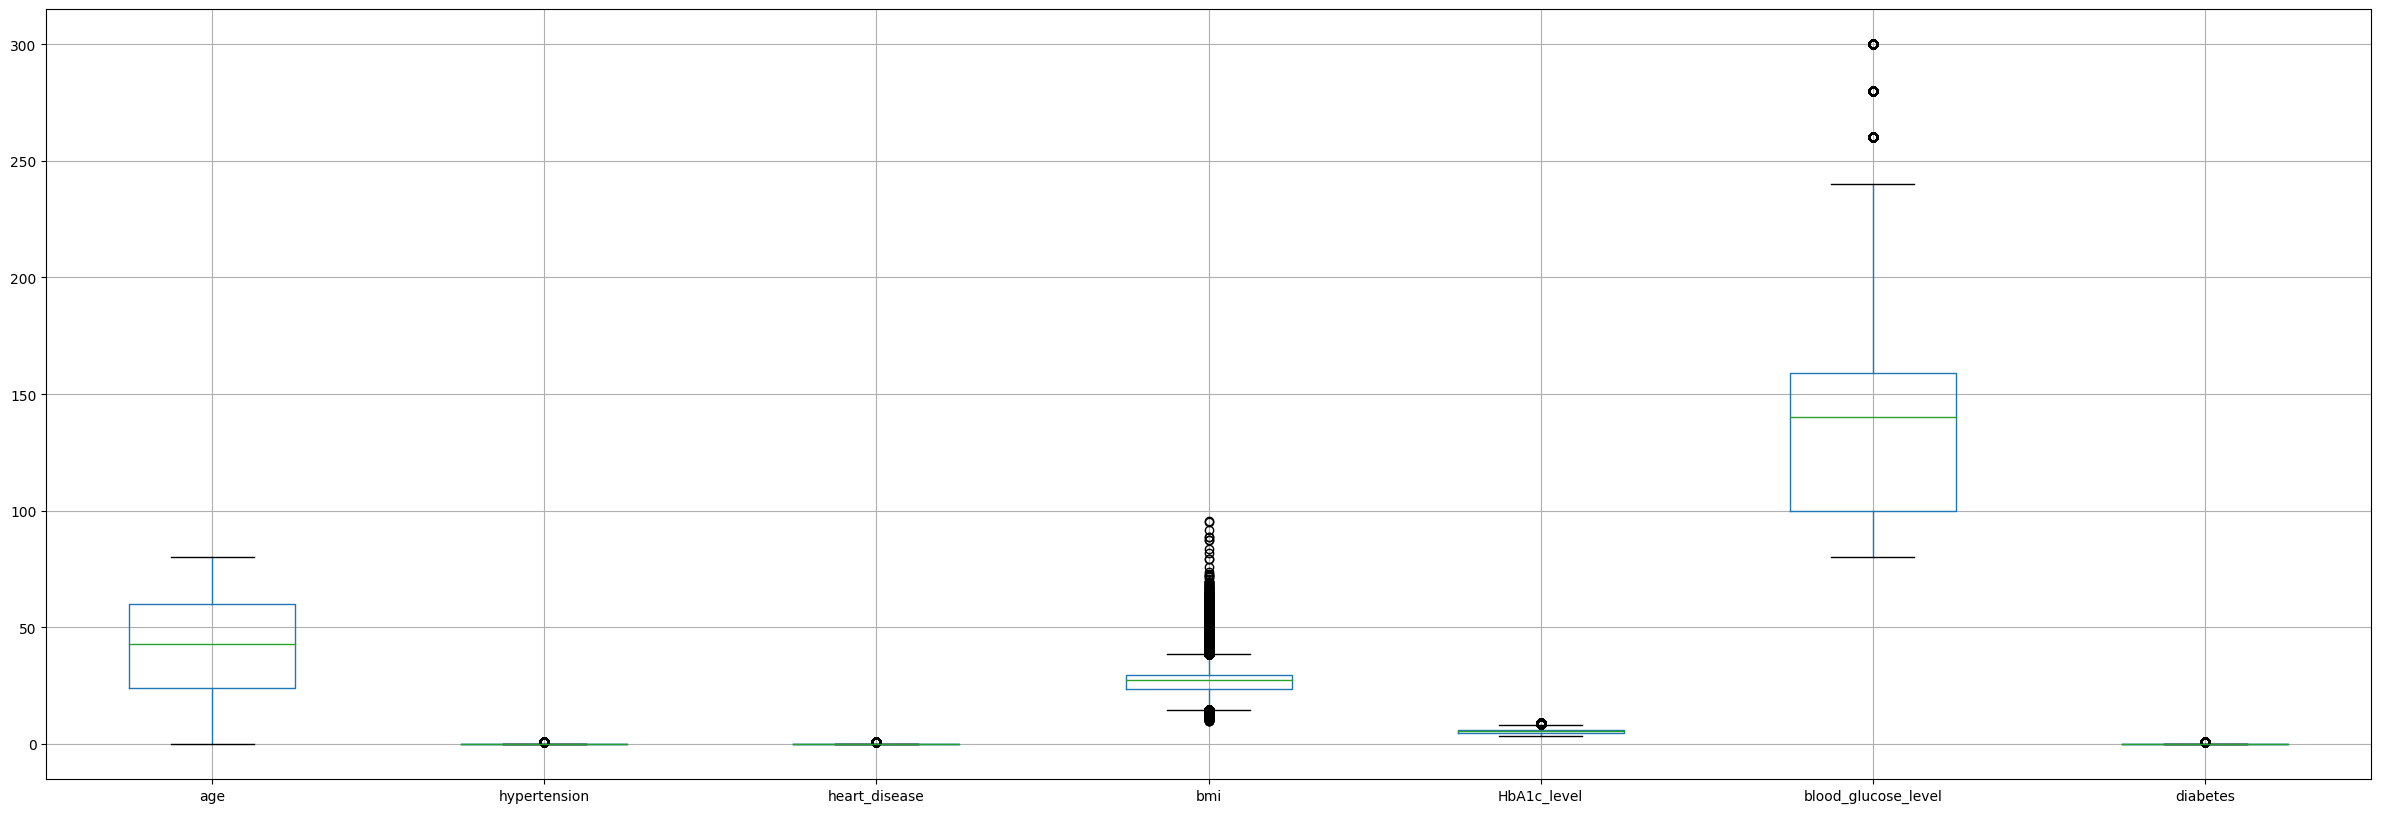

In [55]:
# prompt: show boxplot for all featuers for showing outliers

dataset.boxplot(figsize=(30,10))

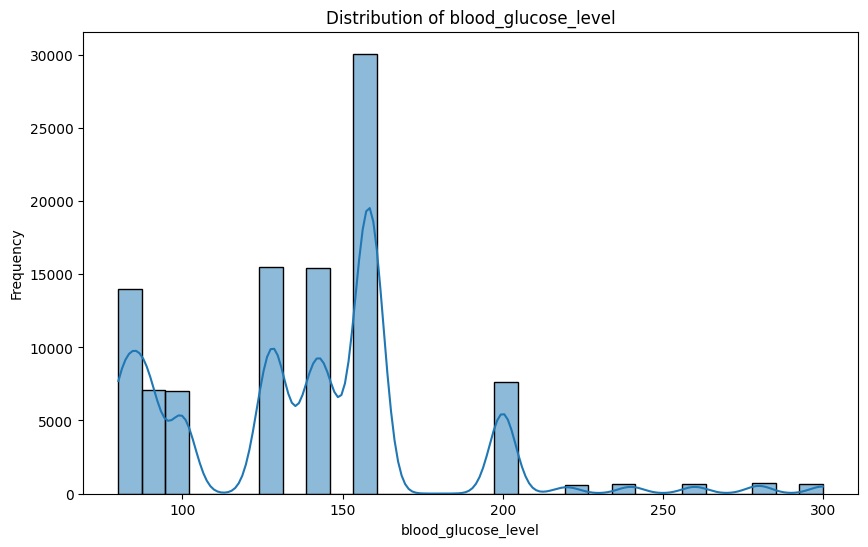

In [56]:
#Distribution of blood_glucose_level
plt.figure(figsize=(10, 6))
sns.histplot(dataset['blood_glucose_level'], bins=30, kde=True)
plt.title('Distribution of blood_glucose_level')
plt.xlabel('blood_glucose_level')
plt.ylabel('Frequency')
plt.show()

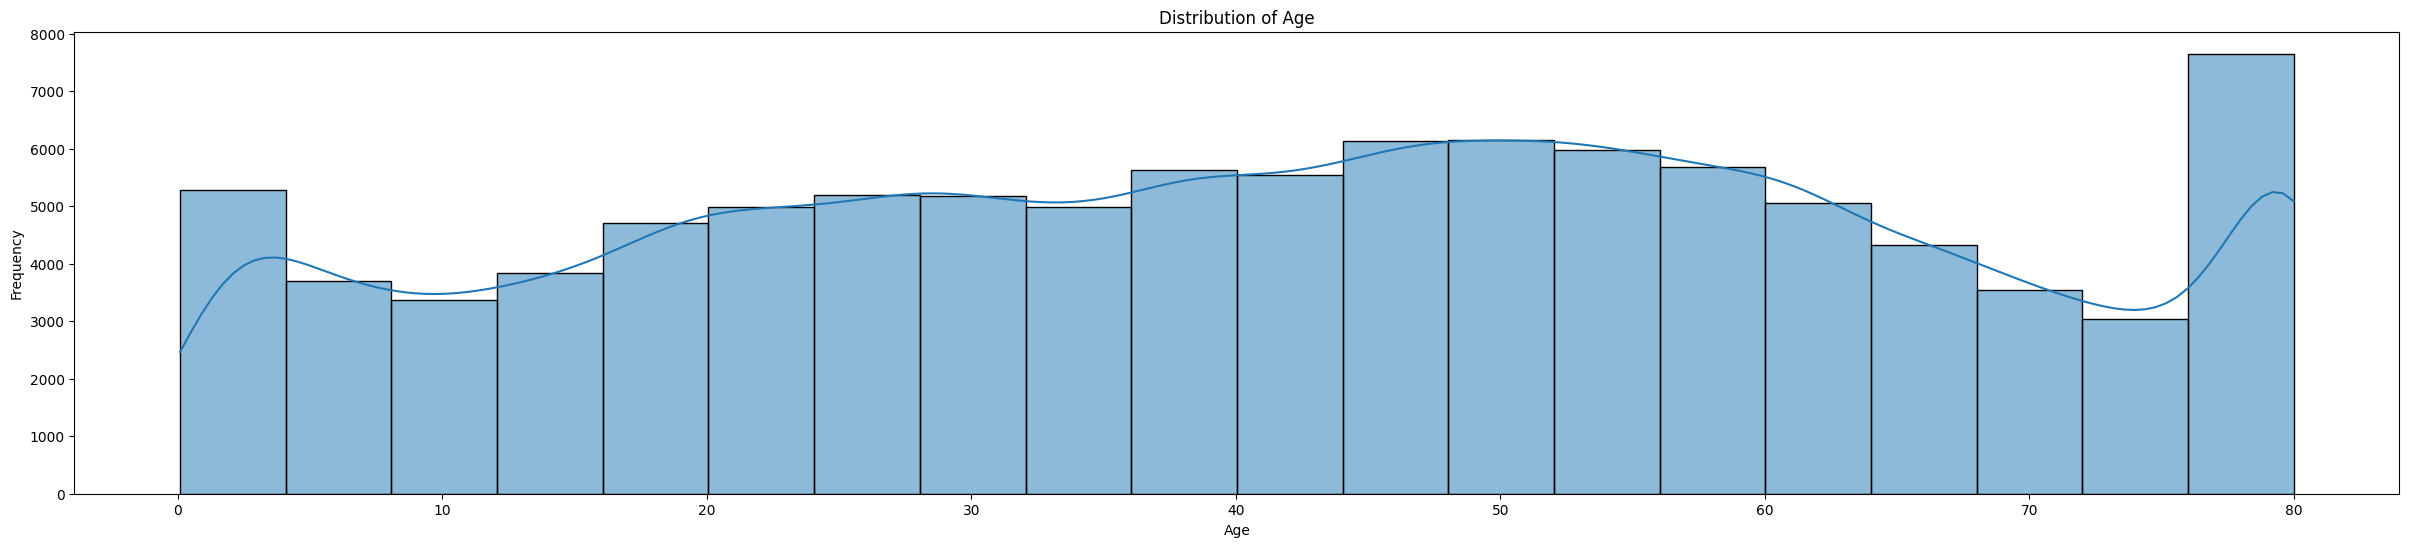

In [57]:
# prompt: #Age Level Distribution

plt.figure(figsize=(30, 6))
sns.histplot(dataset['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In [101]:
print(dataset.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


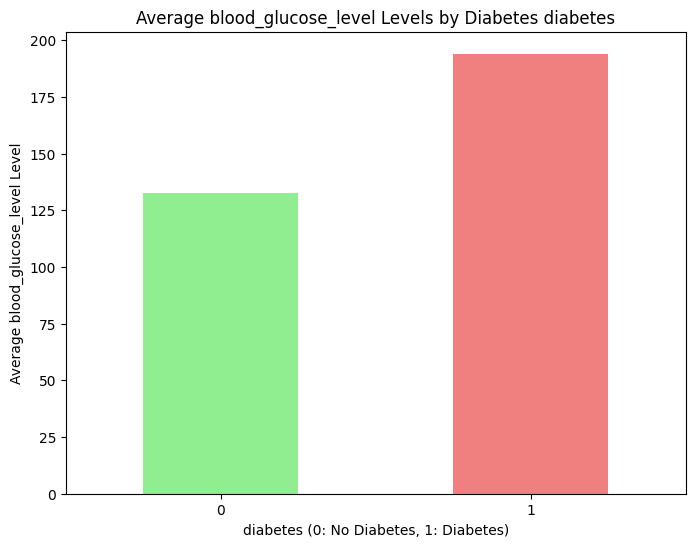

In [103]:
# Insight 2: Glucose Levels by Outcome (Diabetic or Not)
plt.figure(figsize=(8, 6))
dataset.groupby('diabetes')['blood_glucose_level'].mean().plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Average blood_glucose_level Levels by Diabetes diabetes')
plt.xlabel('diabetes (0: No Diabetes, 1: Diabetes)')
plt.ylabel('Average blood_glucose_level Level')
plt.xticks(rotation=0)
plt.show()
# Explanation: The bar chart compares the average glucose levels for individuals with and without diabetes, providing insights into the correlation between glucose levels and diabetes outcome.


#Preprocessing

## check for null values

In [61]:
dataset.isnull().sum()

gender                     0
age                        0
hypertension               0
heart_disease              0
smoking_history        35816
bmi                        0
HbA1c_level                0
blood_glucose_level        0
diabetes                   0
dtype: int64

In [62]:
dataset.isnull().sum().sum()

35816

In [63]:

# Fill missing values with the mean for numerical columns
dataset.fillna(dataset.mean(), inplace=True)

<ipython-input-63-feed1601fcaa>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.fillna(dataset.mean(), inplace=True)


In [64]:
# For categorical columns, fill missing values with mode 'iloc[0] to select first row '
dataset.fillna(dataset.mode().iloc[0], inplace=True)

In [65]:
print("Null values after handling:")
print(dataset.isnull().sum())

Null values after handling:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


##Encoding

In [69]:
#select categorical columns
dataset['diabetes'] = dataset['diabetes'].astype(str)
categorical_columns = dataset.select_dtypes(include=['object']).columns
# Apply LabelEncoder to each categorical column 'object=>numeric'
label_encoder = LabelEncoder()
for column in categorical_columns:
    dataset[column] = label_encoder.fit_transform(dataset[column])

# Display the modified DataFrame
print("DataFrame after Label Encoding:")
print(dataset)


DataFrame after Label Encoding:
       gender   age  hypertension  heart_disease  smoking_history    bmi  \
0           0  80.0             0              1                3  25.19   
1           0  54.0             0              0                5  27.32   
2           1  28.0             0              0                3  27.32   
3           0  36.0             0              0                0  23.45   
4           1  76.0             1              1                0  20.14   
...       ...   ...           ...            ...              ...    ...   
99995       0  80.0             0              0                5  27.32   
99996       0   2.0             0              0                5  17.37   
99997       1  66.0             0              0                2  27.83   
99998       0  24.0             0              0                3  35.42   
99999       0  57.0             0              0                0  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0  

##Scalling using Robust Scaller for handling outliers

In [70]:
# Create a RobustScaler object
rc = RobustScaler()

# Fit and transform the dataset
scaled_data = rc.fit_transform(dataset)
print(scaled_data)

[[ 0.          1.02777778  0.         ...  0.57142857  0.
   0.        ]
 [ 0.          0.30555556  0.         ...  0.57142857 -1.01694915
   0.        ]
 [ 1.         -0.41666667  0.         ... -0.07142857  0.30508475
   0.        ]
 ...
 [ 1.          0.63888889  0.         ... -0.07142857  0.25423729
   0.        ]
 [ 0.         -0.52777778  0.         ... -1.28571429 -0.6779661
   0.        ]
 [ 0.          0.38888889  0.         ...  0.57142857 -0.84745763
   0.        ]]


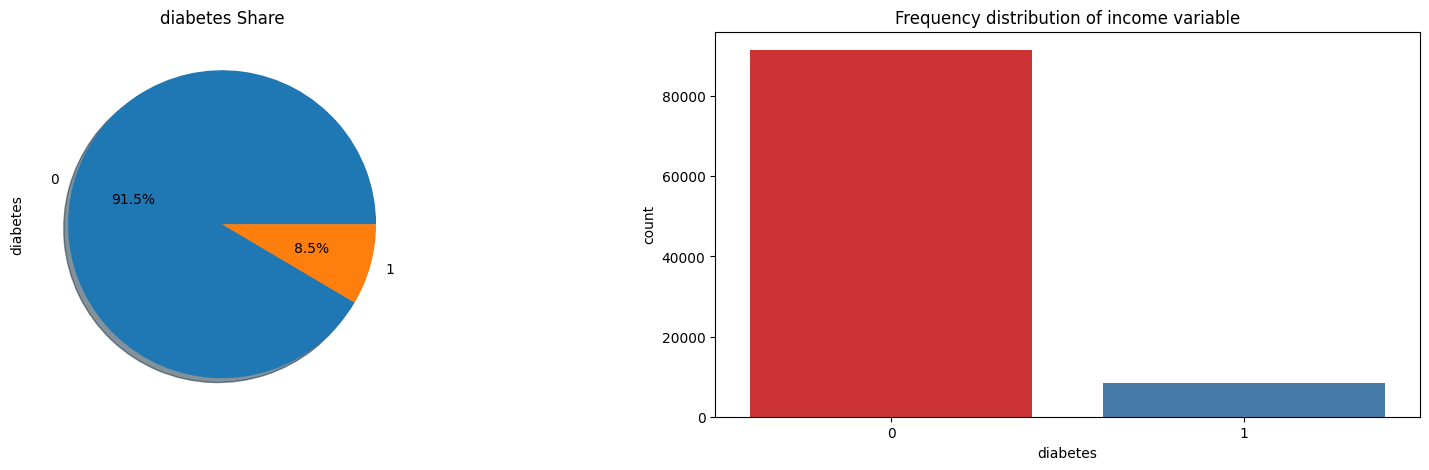

In [71]:
#Income Distribution before handling imbalanced
f,ax=plt.subplots(1,2,figsize=(20,5))
ax[0] = dataset['diabetes'].value_counts().plot.pie(explode=[0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('diabetes Share')

ax[1] = sns.countplot(x="diabetes", data=dataset, palette="Set1")
ax[1].set_title("Frequency distribution of income variable")

plt.show()

##Handeling the Imbalanced by SMOTE  

In [73]:
# Apply SMOTE to address class imbalance
X = dataset.drop('diabetes', axis=1) # all data features except income
Y = dataset['diabetes']              # put income (target) in y

# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42) ##random numbers generated by the SMOTE algorithm are the same every time you run the code
X_resampled, Y_resampled = smote.fit_resample(X, Y) ##then applied to the original dataset to oversample the minority class then store x,y new after resambling in x-resamble y-resamble

# Create a DataFrame with the resampled data
data_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(Y_resampled, name='diabetes')], axis=1)



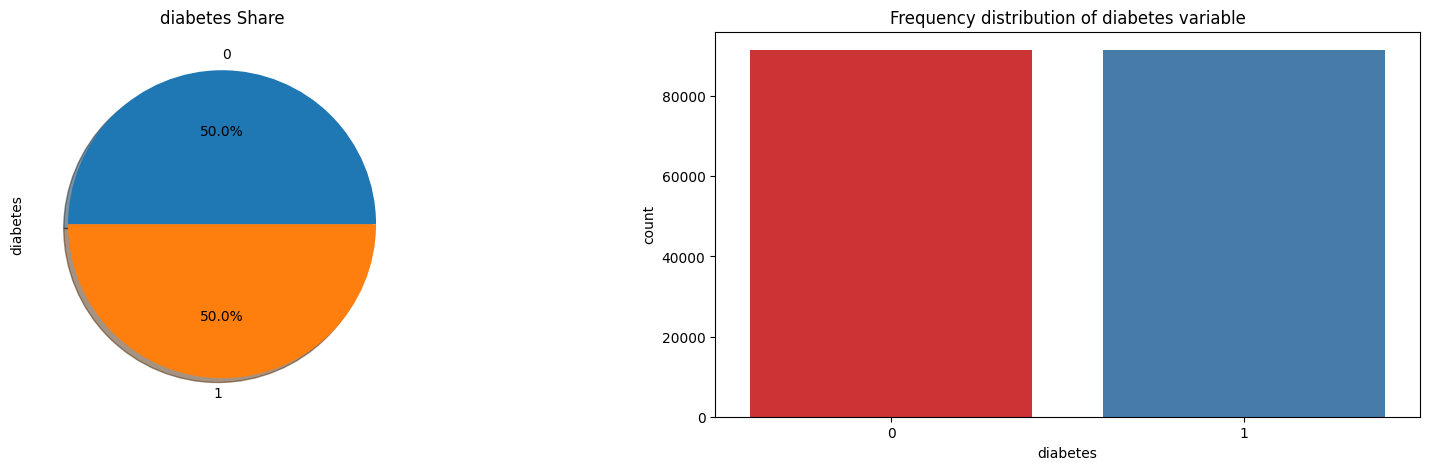

In [74]:
#Income Distribution after handling imbalanced
f,ax=plt.subplots(1,2,figsize=(20,5))
ax[0] = data_resampled['diabetes'].value_counts().plot.pie(explode=[0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('diabetes Share')

ax[1] = sns.countplot(x="diabetes", data=data_resampled, palette="Set1")
ax[1].set_title("Frequency distribution of diabetes variable")
plt.show()

##Correlation

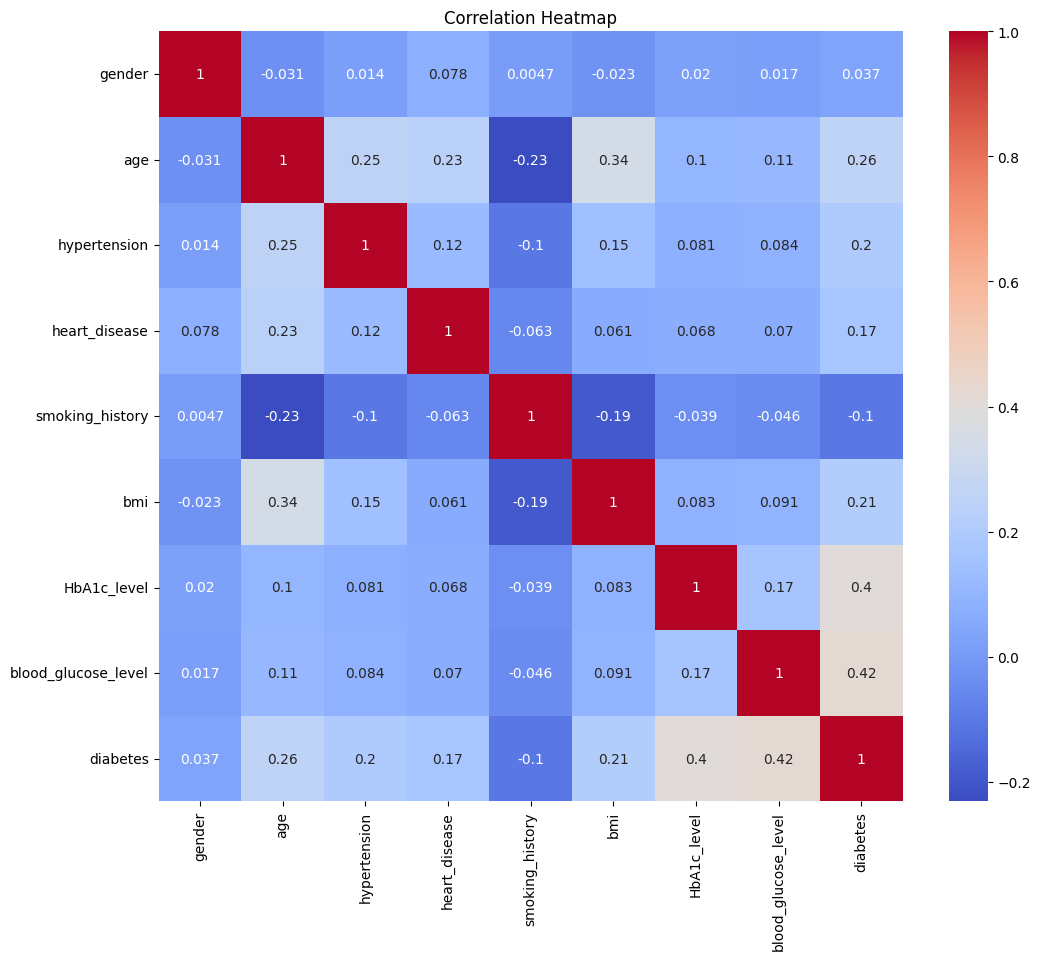

In [75]:
# prompt: plot correlations heatmap (features that impact on diabetes positively or negatively)

plt.figure(figsize=(12, 10))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Train & test your models

In [76]:
# train=>80% test=>20%
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42)

In [77]:
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (146400, 8)
X_test shape: (36600, 8)
y_train shape: (146400,)
y_test shape: (36600,)


#Modelling


In [78]:
from sklearn.ensemble import RandomForestClassifier


# Define the classification models
model = RandomForestClassifier()

# Train and evaluate each model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"{model.__class__.__name__} Accuracy: {accuracy*100}")


RandomForestClassifier Accuracy: 97.44535519125684


In [79]:
# Evaluate the model using confusion matrix
# True Positive - False Positive
# False Negative - True Negative

print(confusion_matrix(y_test, y_pred))

[[17835   458]
 [  477 17830]]


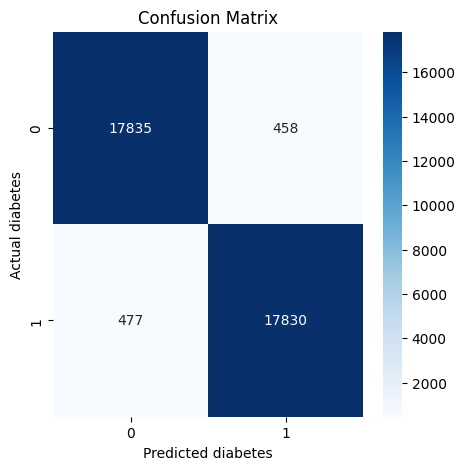

In [80]:
# plot Confusion Matrix

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted diabetes')
plt.ylabel('Actual diabetes')
plt.title('Confusion Matrix')
plt.show()


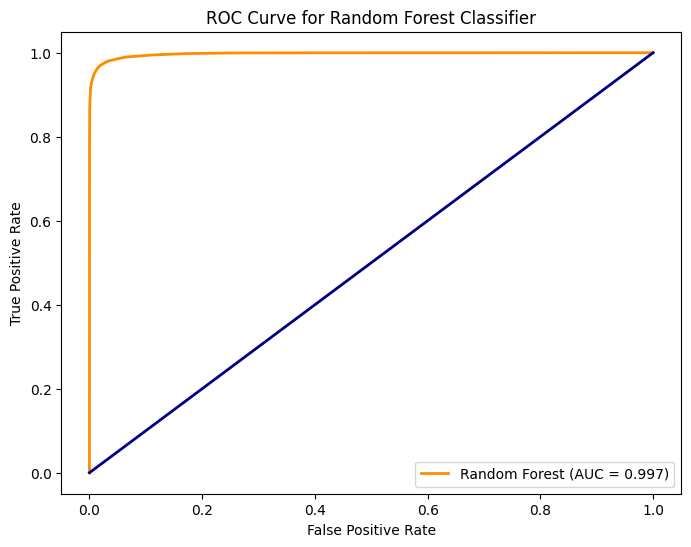

In [96]:
# diagnal indicate perfomormance of model
from sklearn.metrics import roc_curve, auc
# Predict probabilities of the positive class for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Random Forest (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='solid')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()




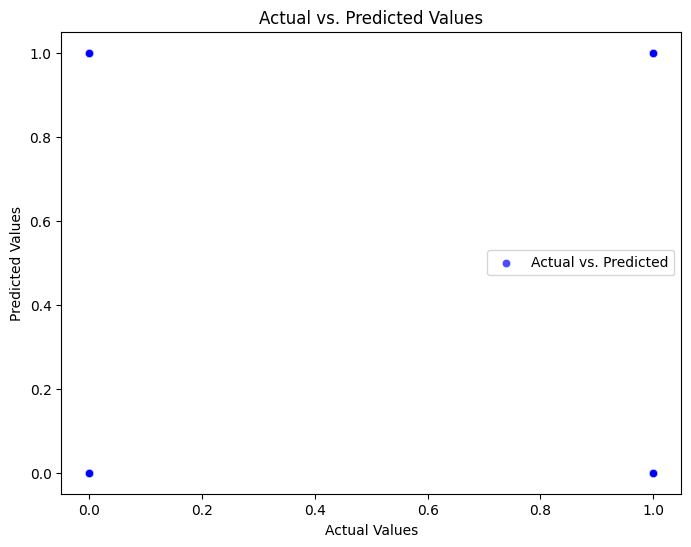

In [83]:
# Create a DataFrame with actual and predicted results
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Visualize the dataset after performing the model
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=df_results, alpha=0.7, color='blue', label='Actual vs. Predicted')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [ ]:
# # Predict probabilities of the positive class for the test set

# y_pred_proba = model.predict_proba(X_test)[:, 1]

# # Compute ROC curve and AUC for Random Forest
# rf_fpr, rf_tpr, thresholds_rf = roc_curve(y_test, y_pred_proba)
# auc_rf = auc(rf_fpr, rf_tpr)

# # Plot ROC curve for Random Forest
# plt.figure(figsize=(8, 6), dpi=100)
# plt.plot(rf_fpr, rf_tpr, linestyle='-', label='Random Forest (AUC = %0.3f)' % auc_rf)

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Random Forest Classifier')
# plt.legend(loc='lower right')
# plt.show()